In [151]:
# %pip install pip --upgrade
# %pip install networkx
# # %pip install matplotlib
# %pip uninstall -y pydot
# # %pip install graphviz
# %pip install pygraphviz

Found existing installation: pydot 1.4.2
Uninstalling pydot-1.4.2:
  Successfully uninstalled pydot-1.4.2
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [154]:
# import json
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
from networkx.drawing.nx_agraph import graphviz_layout


In [83]:
# get the names of the CFR titles from the toc file
title_number = "12"
directory = f"{title_number}CFR"
# toc_file = f"{title_number}CFR/title-{title_number}.json"
# json_toc = json.load(open(toc_file, "r"))
# base_url = url = "https://www.ecfr.gov/api/renderer/v1/content/enhanced/"
# base_date = "2023-09-28"
docs = [doc.split('\t')[1].strip() for doc in open(f"{directory}/{directory}toc.txt", "r").readlines()]
print(docs[:5])

['12-I-1', '12-I-2', '12-I-3', '12-I-4', '12-I-5']


In [84]:
# convert the toc file into a list of filenames
def process_docs(s):
    s = s[s.find("-")+1:]
    modified_s = s[:].translate(str.maketrans('-', '_'))
    
    if modified_s.count('_') == 1:
        modified_s = modified_s.replace('_', '__')
    return ''+directory+'/title_'+modified_s+'.html'

filenames = [process_docs(doc) for doc in docs]

list(zip(filenames[:5], docs[:5]))  

[('12CFR/title_I__1.html', '12-I-1'),
 ('12CFR/title_I__2.html', '12-I-2'),
 ('12CFR/title_I__3.html', '12-I-3'),
 ('12CFR/title_I__4.html', '12-I-4'),
 ('12CFR/title_I__5.html', '12-I-5')]

In [85]:
# let's try to build a graph of relationships between the sections
a_file = filenames[0]
print(a_file)
with open(a_file, 'r') as file:
    html_content = file.read()

soup = BeautifulSoup(html_content, 'html.parser')

divs = soup.find_all('div', {'id': True})

relationships = {}
for div in divs:
    div_id = div['id']
    child_divs = div.find_all('div', {'id': True}, recursive=False)  # immediate children only
    child_ids = [child_div['id'] for child_div in child_divs]
    relationships[div_id] = child_ids

# print(soup.prettify())

12CFR/title_I__1.html


In [183]:
# put it in pandas

# This list will store the records, each as a dictionary
data_records = []

def extract_internal_id(href):
    """Extract internal ID from the href if it exists."""
    if '#' in href:
        return href.split('#')[-1]
    return None

# Parse the HTML for divs, paragraphs, and links
for div in soup.find_all('div', id=True):
    # ignore divs with class "subject-group" as they are not used
    if 'subject-group' in div.get('class', []):
        continue


    div_id = div['id']

    # Extract the paragraph text; assuming only one paragraph per div
    paragraph_text = div.find('p').get_text(strip=True) if div.find('p') else ''

     # Identify child elements. We consider 'div' elements within the current 'div' as its children.
    child_ids = [child_div.get('id') for child_div in div.find_all('div', id=True)]
    
    # Initialize containers for the links
    cfr_links = []  # for links of class "cfr" (internal)
    other_links = []  # for links not having "cfr" class (considered external)
    link_targets = []  # for storing target IDs from internal links

    # Search for links and categorize them
    for a_tag in div.find_all('a', href=True):
        link_class = a_tag.get('class', [])
        href = a_tag['href']

        if "cfr" in link_class:
            cfr_links.append(href)
            
            # Extract target ID from internal link and store it
            target_id = extract_internal_id(href)
            if target_id:
                link_targets.append(target_id)  # Just store the target ID
        else:
            other_links.append(href)  # If not "cfr", considered as external link

    # Construct the record and add it to the list
    record = {
        'id': div_id,
        'text': paragraph_text,
        'child_ids': child_ids,
        'cfr_links': cfr_links,  # internal links
        'other_links': other_links,  # external links
        'link_targets': link_targets,  # target IDs from internal links
    }
    data_records.append(record)

# Create a pandas DataFrame from the list of records
df = pd.DataFrame(data_records)

# To see the DataFrame
# print(df.head())

# 'df' is now a pandas DataFrame, where each row corresponds to a paragraph, 
# containing the ID, text, internal links (cfr), other links (external), and just the target IDs from link relations.

# Set 'id' as the index of your DataFrame if it's not already
df.set_index('id', inplace=True)

# Now you can select rows by id
selected_row = df.loc['p-1.2(a)']

selected_row



text                                 (a)Capital and surplusmeans:
child_ids       [p-1.2(a)(1), p-1.2(a)(1)(i), p-1.2(a)(1)(ii),...
cfr_links       [/on/2023-09-28/title-12/part-3, /on/2023-09-2...
other_links                                                    []
link_targets                                     [p-1.2(a)(2)(i)]
Name: p-1.2(a), dtype: object

In [189]:
# Create a new directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node_id in df.index:
    node_text = df.at[node_id, 'text']
    G.add_node(node_id, text=node_text)

# Add edges to the graph based on link targets and child relationships
for node_id, row in df.iterrows():
    # Add edges for link targets
    for target_id in row['link_targets']:
        if target_id in df.index:
            G.add_edge(node_id, target_id)

    # Add edges for child relationships
    for child_id in row['child_ids']:
        if child_id in df.index:
            G.add_edge(node_id, child_id)  # Adding an edge from parent to child


for node in G.nodes():
    new_label = node.replace('p-', '')
    new_label = new_label.replace('(', '\n(')
    G = nx.relabel_nodes(G, {node: new_label})


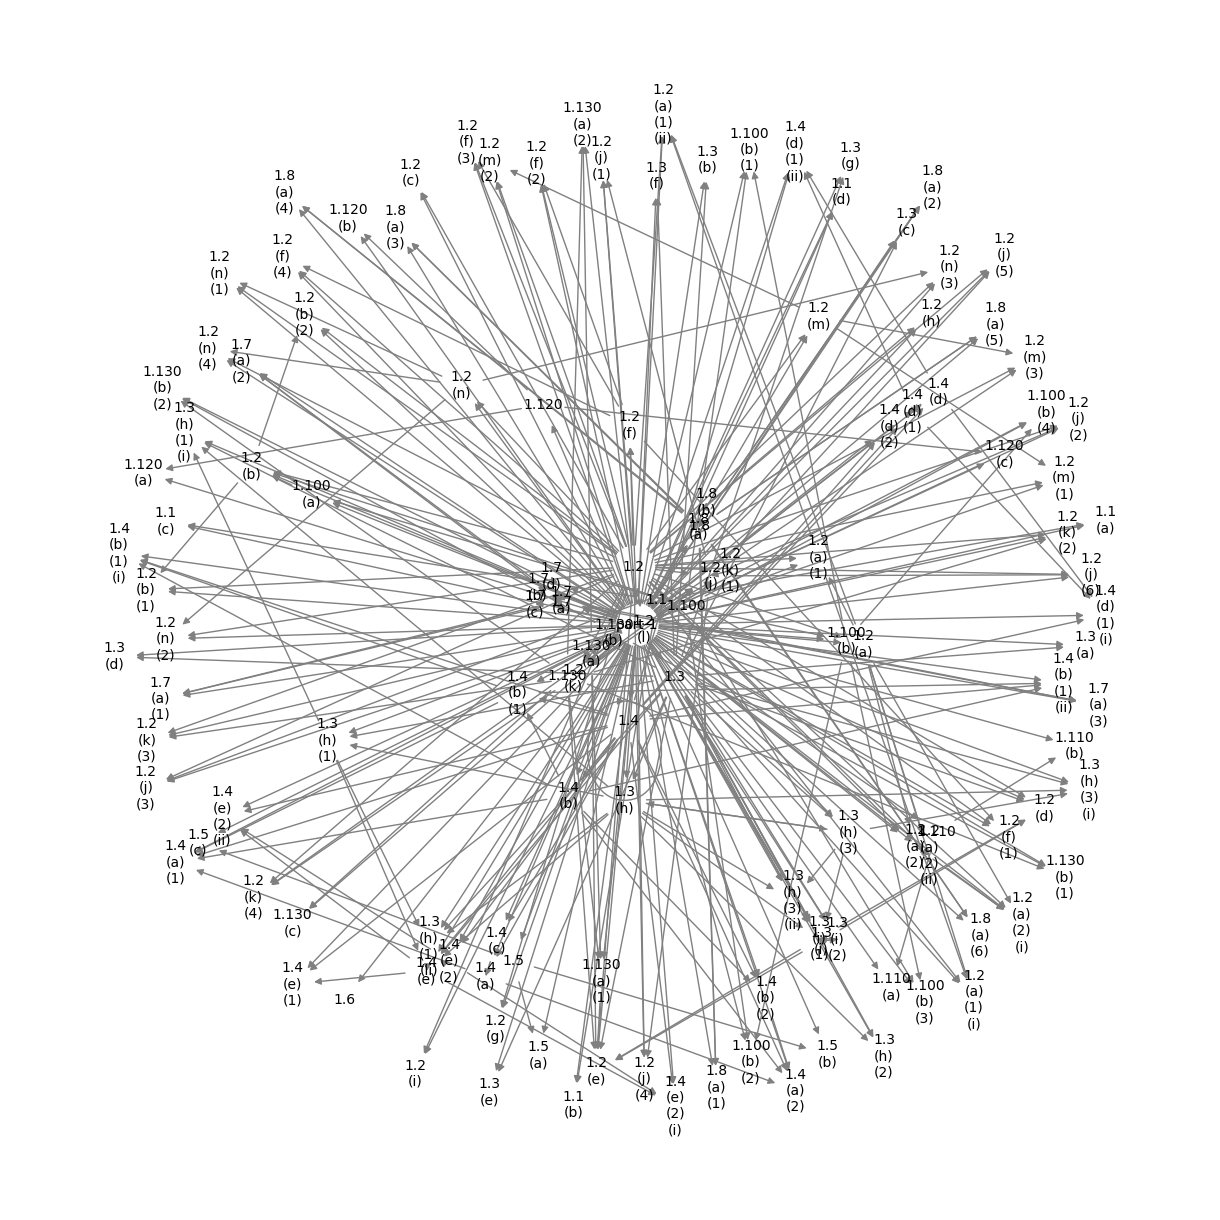

In [190]:

# Draw the graph
pos = nx.spring_layout(G, seed=7)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_color='none', node_size=1000, edge_color='gray', linewidths=1, font_size=10)
plt.show()


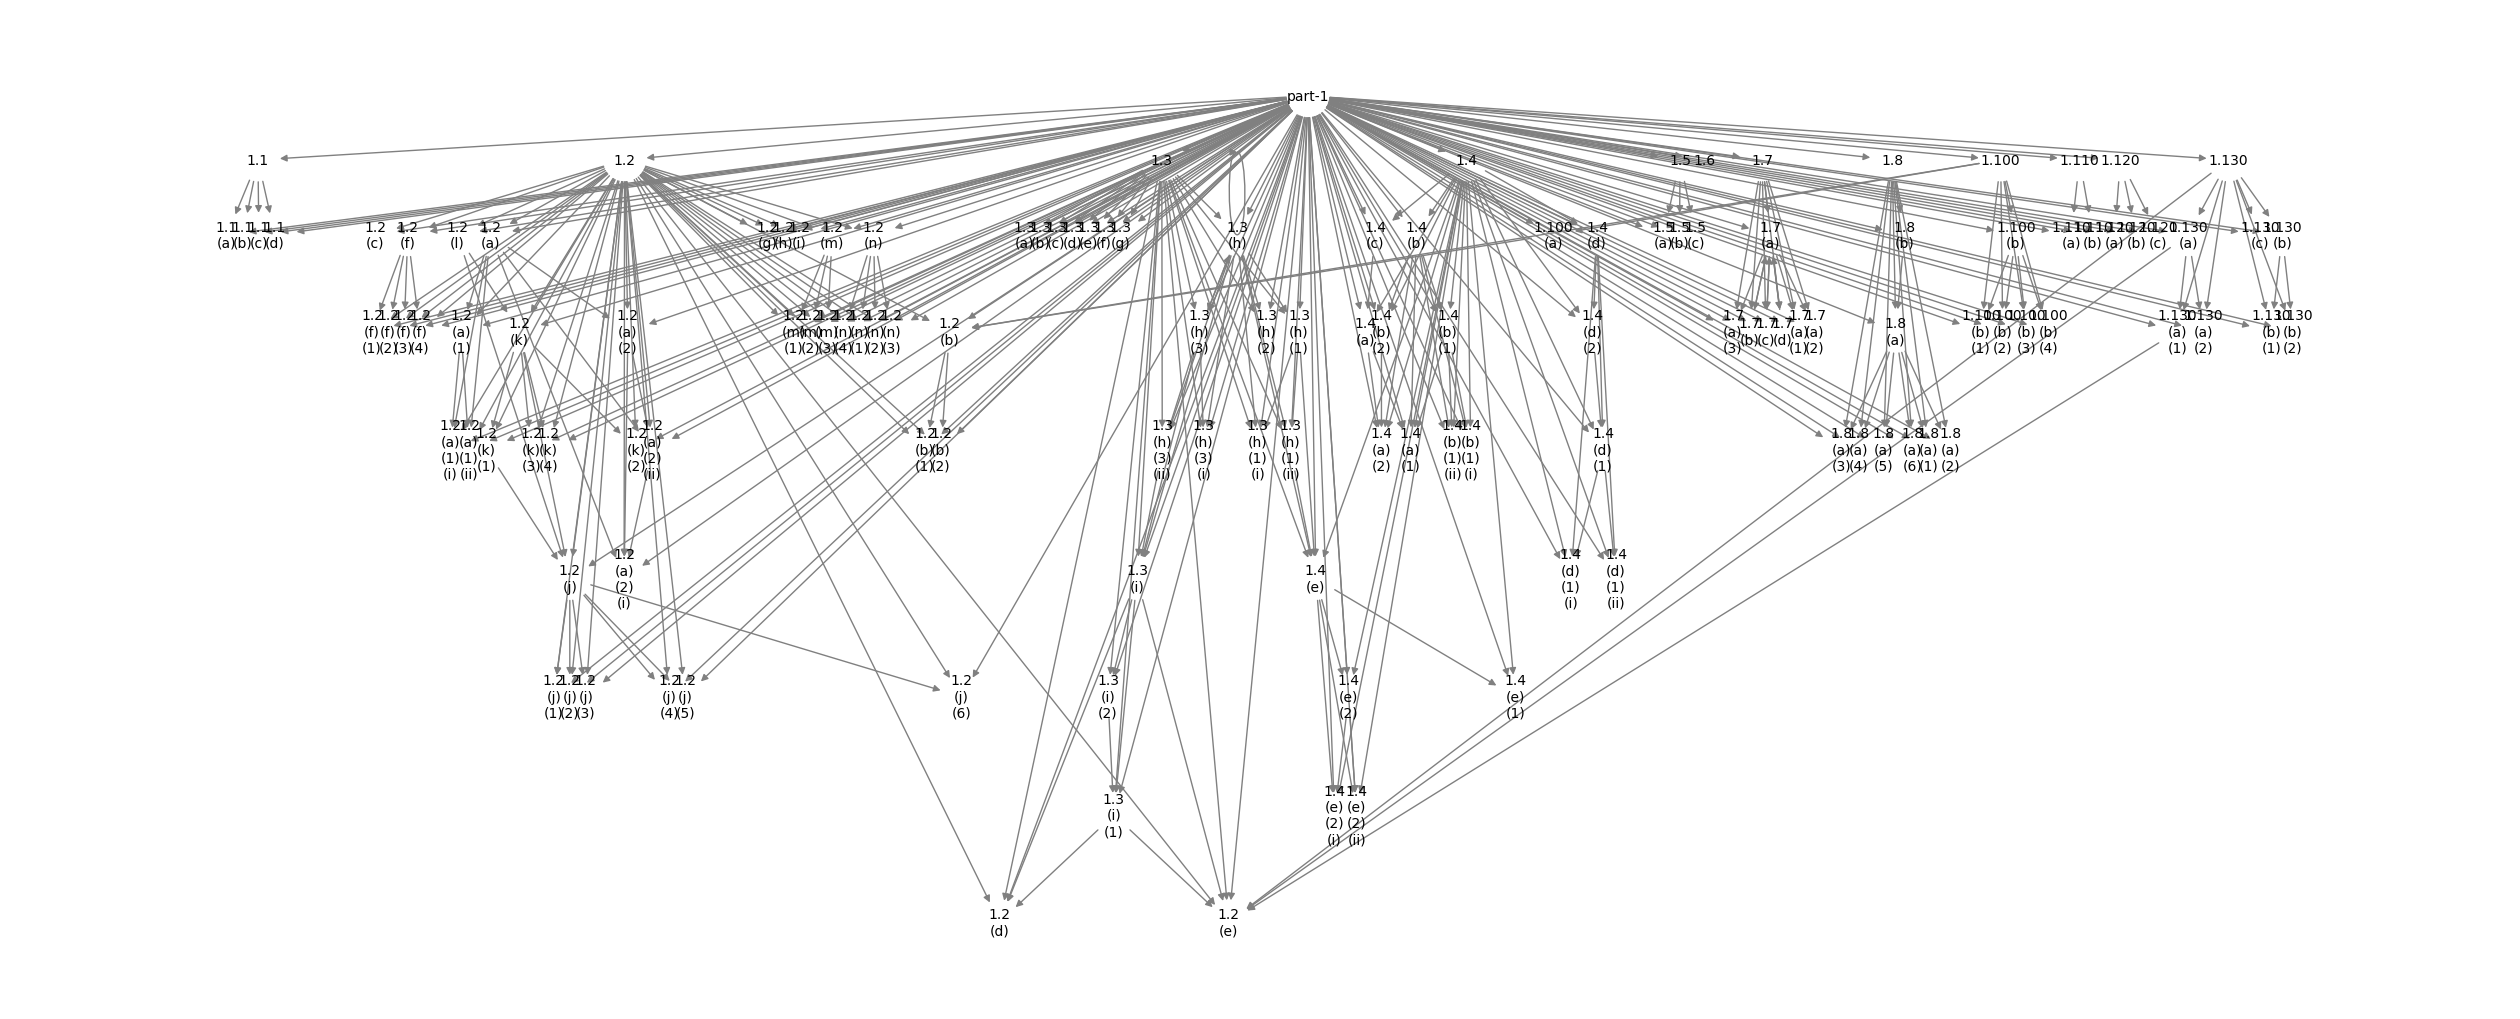

In [204]:
# Create a new graph for visualization purposes only, preserving the structure but not the detailed attributes.
G_simple = nx.DiGraph()
G_simple.add_nodes_from(G.nodes())
G_simple.add_edges_from(G.edges())

# Increase the figure size for better visualization space
plt.figure(figsize=(25, 10))

# Generate the layout and draw the graph, incorporating custom Graphviz attributes
pos = graphviz_layout(G_simple, prog='dot', args='-Goverlap=compress -Gsep=4')
nx.draw(G_simple, pos, with_labels=True, node_color='none', node_size=1000, edge_color='gray', linewidths=1, font_size=10)
plt.show()

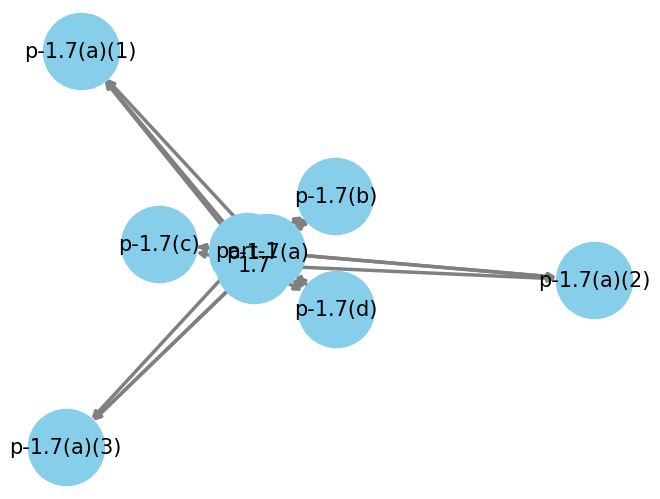

In [136]:
all_nodes = list(G.nodes())
node_of_interest = random.choice(all_nodes)

# Extract the relevant nodes and edges around the random paragraph
ancestors = nx.ancestors(G, node_of_interest)
descendants = nx.descendants(G, node_of_interest)

# Combine the sets and add the original node
nodes_set = ancestors.union(descendants)
nodes_set.add(node_of_interest)

# Create subgraph
subgraph = G.subgraph(nodes_set)

# Visualize the subgraph
pos = nx.spring_layout(subgraph, k=0.5)  # Adjust 'k' as necessary to spread out nodes
nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=15, width=2.5, edge_color='gray')
plt.show()

In [134]:
nodes_with_external = df[df['other_links'].astype(bool)]
nodes_with_external['other_links']

id
part-1                               [https://www.govinfo.gov/link/uscode/12/1, htt...
1.1                                  [https://www.govinfo.gov/link/uscode/12/1, htt...
p-1.1(a)                             [https://www.govinfo.gov/link/uscode/12/1, htt...
p-1.1(b)                                   [https://www.govinfo.gov/link/uscode/12/24]
p-1.1(c)                                  [https://www.govinfo.gov/link/uscode/12/335]
p-1.1(d)                                   [https://www.govinfo.gov/link/uscode/12/24]
1.2                                  [https://www.govinfo.gov/link/uscode/15/80a-8,...
p-1.2(c)                                [https://www.govinfo.gov/link/uscode/15/80a-8]
p-1.2(f)                             [https://www.govinfo.gov/link/uscode/15/77a, h...
p-1.2(f)(1)                               [https://www.govinfo.gov/link/uscode/15/77a]
p-1.2(f)(2)                               [https://www.govinfo.gov/link/uscode/15/77c]
p-1.2(j)                             [ht